In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# IMPORT PACKAGES

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as feature
import cmocean.cm
import pandas as pd
import xarray as xr
import collections
from scipy.stats import ttest_ind, ttest_rel
# fix to cartopy issue right now
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

In [3]:
# CODE TO CALCULATE SEASONAL AVERAGE AND STATISTICAL SIGNIFICANCE

# Taken from: https://xarray.pydata.org/en/v0.14.0/examples/monthly-means.html
# However test plot in "Seasonal Mean Example" produces somewhat different results-- not sure why.
# usage example: ds_weighted = season_mean(ds,calendar='noleap')

dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
       'julian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]}

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

def season_mean(ds, calendar='standard'):

    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar),
                                coords=[ds.time], name='month_length')
    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')

def annual_season_mean(ds, calendar='standard'): # Added 7-9-20
    # TRUNCATE TIME SERIES IN ADVANCE SO THERE ARE ONLY COMPLETE YEARS, OTHERWISE GET INF/0 AT END FOR SOME SEASONS
    ml = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar),
                                coords=[ds.time], name='month_length') # ml stands for month_length
    ml_seas = {}
    ml_seas_sums = {}
    weights = {}
    ds_seas = {}
    ann_seas_mean_v1 = {}
    for seas in ['DJF','MAM','JJA','SON']:
        ml_seas[seas] = ml.where(ds['time.season'] == seas)
        ml_seas_sums[seas] = ml_seas[seas].rolling(min_periods=3, center=True, time=3).sum()
        if seas == 'DJF':
            ml_seas[seas] = ml_seas[seas].shift(time=1) # done to ensure weights for consecutive D-J-F add up to 1 despite crossing year
        weights[seas] = ml_seas[seas].groupby('time.year') / ml_seas_sums[seas].groupby('time.year').sum()
        
        ds_seas[seas] = ds.where(ds['time.season'] == seas)
        if seas == 'DJF':
            ds_seas[seas] = ds_seas[seas].shift(time=1)
        ann_seas_mean_v1[seas] = (ds_seas[seas] * weights[seas]).groupby('time.year').sum(dim='time') # 0 AT END IF NOT COMPLETE YEAR
    ann_seas_mean_v1['DJF'] = ann_seas_mean_v1['DJF'].isel(year=slice(1,len(ann_seas_mean_v1['DJF'].year)))
    return ann_seas_mean_v1

#STATISTICAL SIGNIFICANCE TEST
#test with identical sample sizes

def sigtest(yearmean1,yearmean2,timemean1,timemean2):
    ptvals = ttest_rel(yearmean1,yearmean2, axis=0)
    diff = timemean1-timemean2
    diff_mask = np.ma.masked_where(ptvals[1] > 0.1,diff)
    return diff,diff_mask,ptvals

def sigtest2n(yearmean1,yearmean2,timemean1,timemean2):
    ptvals = ttest_ind(yearmean1,yearmean2, axis=0, equal_var = False)
    diff = timemean1-timemean2
    diff_mask = np.ma.masked_where(ptvals[1] > 0.1,diff)
    return diff,diff_mask,ptvals


In [4]:
# PATHS TO DATA FILES

direc = '/tigress/GEOCLIM/janewb/MODEL_OUT'
diag = 't_surf'
files = {}

files['ctrl'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/'+diag+'.00010101-03000101.atmos_month.nc'
files['cam'] = '/tigress/janewb/MODEL_OUT_HERE/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1_CAM/TIMESERIES/'+diag+'.00010101-02050101.atmos_month.nc'
files['hitopo'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1/TIMESERIES/'+diag+'.00010101-06000101.atmos_month.nc'
files['obs'] = '/tigress/gvecchi/DATA/HADISST/HadISST_sst.nc'
files['cesm_cam'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/ccsm4pi_topo2.pop.h.SSTregrid.000101-029912.nc'
files['cesm_ctrl'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/b40.1850.track1.1deg.006.pop.h.SSTregrid.100001-130012.nc'


In [5]:
# DATA CLEANING
x = 'lon'
y = 'lat'
sst_var = 'sst'
units = 'C'
model_tmin = '0031'
model_tmax = '0200'
obs_tmin = '1947'
obs_tmax = '2016'
calendars = {'ctrl':'noleap',
             'cam':'noleap',
             'hitopo':'noleap',
             'obs':'gregorian',
             'cesm_ctrl':'noleap',
             'cesm_cam':'noleap'
            }

dat = {}
sst = {}
tsel = {}

# FLOR Runs

for key in ['ctrl','cam','hitopo']:
    dat[key] = xr.open_dataset(files[key])
    dat[key] = dat[key].rename({'t_surf':'sst'})
    sst[key] = dat[key].sst-273.15
    sst[key].attrs = dat[key].attrs
    sst[key].attrs['units'] = units
    sst[key] = sst[key].rename({'grid_xt': 'lon','grid_yt': 'lat'})
    tsel[key] = sst[key].sel(time = slice(model_tmin,model_tmax))
    
# CESM RUNS

for key in ['cesm_ctrl','cesm_cam']:
    dat[key] = xr.open_dataset(files[key])
    dat[key] = dat[key].rename({'sst_regrid':'sst'})
    sst[key] = dat[key].sst
    sst[key].attrs = dat[key].attrs
    sst[key].attrs['units'] = units
    tsel[key] = sst[key]

# OBSERVATIONS

# HADISST
dat['obs'] = xr.open_dataset(files['obs'])
dat['obs'] = dat['obs'].rename({'longitude': 'lon','latitude': 'lat'})
dat['obs'] = dat['obs'].sortby('lat', ascending=True)
dat['obs'] = dat['obs'].assign_coords(lon=(dat['obs'].lon % 360)).roll(lon=180, roll_coords=True)
sst['obs'] = dat['obs'].sst
sst['obs'].attrs = dat['obs'].attrs
tsel['obs'] = sst['obs'].sel(time = slice(obs_tmin,obs_tmax))

In [6]:
# DATA ANALYSIS

tmean = {}
seasmean = {}
ann_seasmean = {}

for key in dat.keys():
    tmean[key] = tsel[key].mean(dim='time')
    seasmean[key] = season_mean(tsel[key],calendar=calendars[key])
    ann_seasmean[key] = annual_season_mean(tsel[key],calendar=calendars[key])
    

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWar

In [7]:
# Calculate difference and statistical significance mask
diff_mask = collections.defaultdict(dict)
diff_mask_cesm = collections.defaultdict(dict)
diff = collections.defaultdict(dict)
diff_cesm = collections.defaultdict(dict)
ptvals = collections.defaultdict(dict)
ptvals_cesm = collections.defaultdict(dict)

seasons = ['DJF','MAM','JJA','SON']


# COMPARING CONTROL AND TOPO. MODEL RUNS

for key in ['hitopo','cam']:
    for seas in seasons:
        diff[key][seas],diff_mask[key][seas],ptvals[key][seas] = sigtest(ann_seasmean[key][seas],ann_seasmean['ctrl'][seas],seasmean[key].sel(season=seas),seasmean['ctrl'].sel(season=seas))

for seas in seasons:
    diff['cesm_cam'][seas],diff_mask['cesm_cam'][seas],ptvals['cesm_cam'][seas] = sigtest2n(ann_seasmean['cesm_cam'][seas].values,ann_seasmean['cesm_ctrl'][seas].values,seasmean['cesm_cam'].sel(season=seas).values,seasmean['cesm_ctrl'].sel(season=seas).values)


# COMPARING CONTROL MODEL RUNS WITH OBS.
seasmean_regrid = {}
ann_seasmean_regrid = collections.defaultdict(dict)

for key in ['obs']:
    seasmean_regrid[key] = seasmean[key].interp_like(tmean['ctrl'],method='linear')
    ann_seasmean_regrid[key][seas] = ann_seasmean[key][seas].interp_like(tmean['ctrl'],method='linear')
    for seas in seasons:
        ann_seasmean_regrid[key][seas] = ann_seasmean[key][seas].interp_like(tmean['ctrl'],method='linear')
        diff[key][seas],diff_mask[key][seas],ptvals[key][seas] = sigtest2n(ann_seasmean_regrid[key][seas].values,ann_seasmean['ctrl'][seas].values,seasmean_regrid[key].sel(season=seas).values,seasmean['ctrl'].sel(season=seas).values)

# Note: mask may not be working for DJF
for key in ['obs']:
    seasmean_regrid[key] = seasmean[key].interp_like(tmean['cesm_ctrl'],method='linear')
    ann_seasmean_regrid[key][seas] = ann_seasmean[key][seas].interp_like(tmean['ctrl'],method='linear')
    for seas in seasons:
        ann_seasmean_regrid[key][seas] = ann_seasmean[key][seas].interp_like(tmean['cesm_ctrl'],method='linear')
        diff_cesm[key][seas],diff_mask_cesm[key][seas],ptvals_cesm[key][seas] = sigtest2n(ann_seasmean_regrid[key][seas].values,ann_seasmean['cesm_ctrl'][seas].values,seasmean_regrid[key].sel(season=seas).values,seasmean['cesm_ctrl'].sel(season=seas).values)


/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:3851: RuntimeWarning: invalid value encountered in subtract
  d = mean1 - mean2
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:97: RuntimeWarning: inv

In [8]:
# REGRID AND CALCULATE DIFFERENCE FROM OBS

regrid = collections.defaultdict(dict)
seasmean_regrid = collections.defaultdict(dict)
diff = collections.defaultdict(dict)
seas_diff = collections.defaultdict(dict)
pdiff = collections.defaultdict(dict)
seas_pdiff = collections.defaultdict(dict)
for key in ['obs']:
    regrid[key] = tmean[key].interp_like(tmean['ctrl'],method='linear')
    seasmean_regrid[key] = seasmean[key].interp_like(tmean['ctrl'],method='linear')
    for run in ['ctrl','hitopo','cam']:
        diff[key][run] = regrid[key] - tmean[run]
        seas_diff[key][run] = seasmean_regrid[key] - seasmean[run]
        pdiff[key][run] = (regrid[key] - tmean[run])/regrid[key]
        seas_pdiff[key][run] = (seasmean_regrid[key] - seasmean[run])/seasmean_regrid[key]
for key in ['obs']:
    regrid[key] = tmean[key].interp_like(tmean['cesm_ctrl'],method='linear')
    seasmean_regrid[key] = seasmean[key].interp_like(tmean['cesm_ctrl'],method='linear')
    for run in ['cesm_ctrl','cesm_cam']:
        diff[key][run] = regrid[key] - tmean[run]
        seas_diff[key][run] = seasmean_regrid[key] - seasmean[run]
        pdiff[key][run] = (regrid[key] - tmean[run])/regrid[key]
        seas_pdiff[key][run] = (seasmean_regrid[key] - seasmean[run])/seasmean_regrid[key]
        

In [9]:
# CALCULATE DIFFERENCE BETWEEN DIFFERENT MODEL RUNS

mdiff = {}
seas_mdiff = {}
for key in ['hitopo','cam']:
    mdiff[key] = tmean[key] - tmean['ctrl']
    seas_mdiff[key] = seasmean[key] - seasmean['ctrl'] 
for key in ['cesm_cam']:
    mdiff[key] = tmean[key] - tmean['cesm_ctrl']
    seas_mdiff[key] = seasmean[key] - seasmean['cesm_ctrl'] 

In [10]:
#TOPOGRAPHY

direc = '/tigress/GEOCLIM/janewb/MODEL_OUT'
topo = {}
topo['obs'] = xr.open_dataset('/tigress/janewb/HiTopo/etopo5.nc').ROSE
topo['ctrl'] = xr.open_dataset(direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/zsurf.nc').ZSURF
topo['cam'] = xr.open_dataset(direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1_CAM/TIMESERIES/zsurf.nc').ZSURF
topo['hitopo'] = xr.open_dataset(direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1/TIMESERIES/zsurf.nc').ZSURF
topo['cesm_ctrl'] = xr.open_dataset('/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_topo_mods/hose1Sv_ccsm4_pi01.cam2.h0.0001-01.nc').PHIS/9.8
topo['cesm_cam'] = xr.open_dataset('/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_topo_mods/shf_heating_topo6.cam2.h0.0001-01.nc').PHIS/9.8

mdiff_topo = {}
for key in ['hitopo','cam']:
    mdiff_topo[key] = topo[key] - topo['ctrl']
for key in ['cesm_ctrl','cesm_cam']:
    mdiff_topo[key] = topo[key] - topo['cesm_ctrl']
 

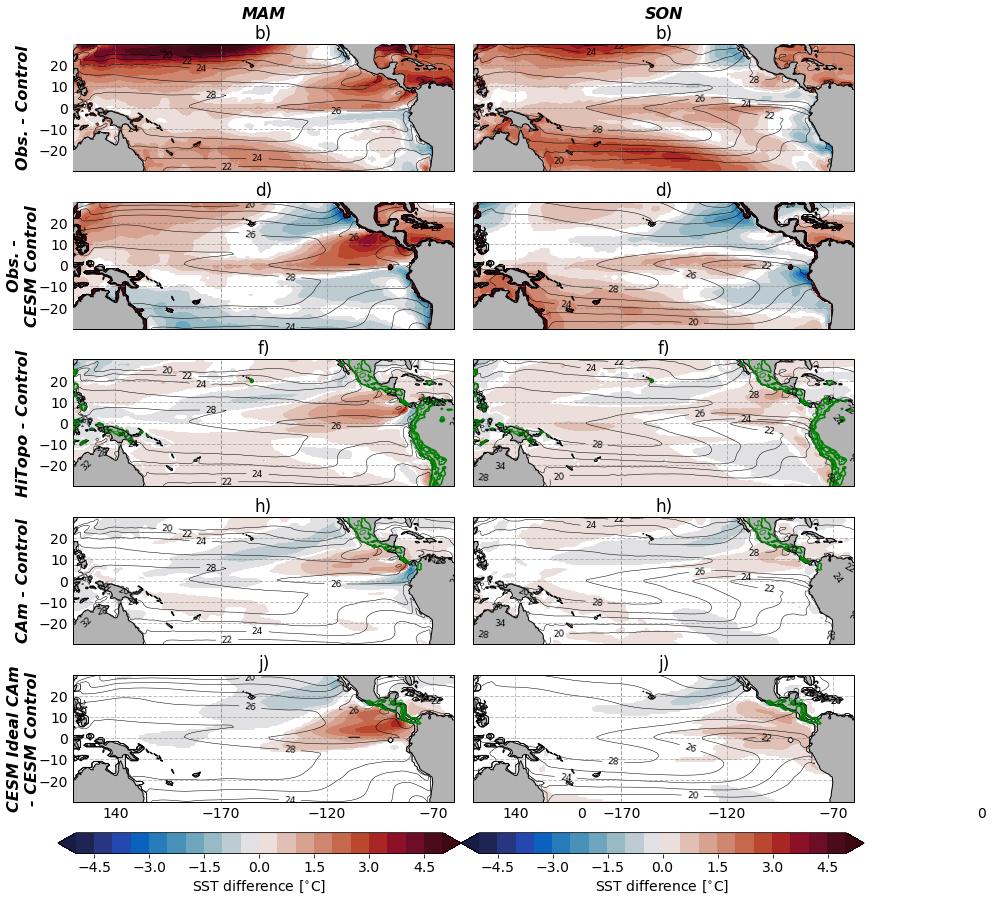

In [22]:
# MAPS COMPARING DIFFERENT MODEL RUNS SEASONAL AVERAGE

fig = plt.figure(figsize=(14,14.5))
plt.rcParams.update({'font.size': 14})
fs_label = 16

lev = np.arange(-5,5.5,0.5)
lev2 = np.arange(20,36,2)
lev3 = np.arange(500,1500,500)
cmap =cmocean.cm.balance
topocolor = 'g'
proj = ccrs.PlateCarree(central_longitude=-180)

latf = seasmean['hitopo'].lat
lonf = seasmean['hitopo'].lon
latc = seasmean['cesm_cam'].lat
lonc = seasmean['cesm_cam'].lon

lw = 1

# MODEL CONTROLS AND BIASES

ax1 = plt.subplot(5,2,1,projection=proj)
ax1.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im1 = plt.contourf(lonf,latf,diff_mask['obs']['MAM'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
CS = seasmean['ctrl'].sel(season='MAM').plot.contour(colors='k',levels=lev2, linewidths=0.5, transform=ccrs.PlateCarree())
ax1.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax1.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax1.set_title('b)')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax2 = plt.subplot(5,2,2,projection=proj)
ax2.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im2 = plt.contourf(lonf,latf,diff_mask['obs']['SON'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
CS = seasmean['ctrl'].sel(season='SON').plot.contour(colors='k',levels=lev2, linewidths=0.5, transform=ccrs.PlateCarree())
ax2.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax2.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax2.set_title('b)')
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabels_bottom = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax3 = plt.subplot(5,2,3,projection=proj)
ax3.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im3 = plt.contourf(lonc,latc,diff_mask_cesm['obs']['MAM'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
CS = seasmean['cesm_ctrl'].sel(season='MAM').plot.contour(colors='k',levels=lev2, linewidths=0.5, transform=ccrs.PlateCarree())
ax3.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax3.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax3.set_title('d)')
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax4 = plt.subplot(5,2,4,projection=proj)
ax4.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im4 = plt.contourf(lonc,latc,diff_mask_cesm['obs']['SON'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
CS = seasmean['cesm_ctrl'].sel(season='SON').plot.contour(colors='k',levels=lev2, linewidths=0.5, transform=ccrs.PlateCarree())
ax4.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax4.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax4.set_title('d)')
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabels_bottom = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

# TOPOGRAPHIC DIFFERENCES

ax5 = plt.subplot(5,2,5,projection=proj)
ax5.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im5 = plt.contourf(lonf,latf,diff_mask['hitopo']['MAM'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
#im1 = seas_mdiff['hitopo'].sel(season='MAM').plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
CS = seasmean['ctrl'].sel(season='MAM').plot.contour(colors='k',levels=lev2, linewidths=0.5, transform=ccrs.PlateCarree())
ax5.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax5.add_feature(feature.LAND, zorder=2, edgecolor='k', facecolor='0.7')
CS = mdiff_topo['hitopo'].plot.contour(zorder=3,colors=topocolor,levels = lev3, transform=ccrs.PlateCarree())
ax5.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax5.set_title('f)')
gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax6 = plt.subplot(5,2,6,projection=proj)
ax6.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im6 = plt.contourf(lonf,latf,diff_mask['hitopo']['SON'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
#im2 = seas_mdiff['hitopo'].sel(season='SON').plot(ax=ax2, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
CS = seasmean['ctrl'].sel(season='SON').plot.contour(colors='k',levels=lev2, linewidths=0.5, transform=ccrs.PlateCarree())
ax6.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax6.add_feature(feature.LAND, zorder=2, edgecolor='k', facecolor = '0.7')
CS = mdiff_topo['hitopo'].plot.contour(zorder=3,colors=topocolor,levels = lev3, transform=ccrs.PlateCarree())
ax6.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax6.set_title('f)')
gl = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabels_bottom = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax7 = plt.subplot(5,2,7,projection=proj)
ax7.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im7 = plt.contourf(lonf,latf,diff_mask['cam']['MAM'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
#seas_mdiff['cam'].sel(season='MAM').plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
CS = seasmean['ctrl'].sel(season='MAM').plot.contour(colors='k',levels=lev2, linewidths=0.5, transform=ccrs.PlateCarree())
ax7.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax7.add_feature(feature.LAND, zorder=2, edgecolor='k', facecolor = '0.7')
CS = mdiff_topo['cam'].plot.contour(zorder=3,colors=topocolor,levels = lev3, transform=ccrs.PlateCarree())
ax7.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax7.set_title('h)')
gl = ax7.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax8 = plt.subplot(5,2,8,projection=proj)
ax8.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im8 = plt.contourf(lonf,latf,diff_mask['cam']['SON'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
#seas_mdiff['cam'].sel(season='SON').plot(ax=ax4, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
CS = seasmean['ctrl'].sel(season='SON').plot.contour(colors='k',levels=lev2, linewidths=0.5, transform=ccrs.PlateCarree())
ax8.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax8.add_feature(feature.LAND, zorder=2, edgecolor='k', facecolor = '0.7')
CS = mdiff_topo['cam'].plot.contour(zorder=3,colors=topocolor,levels = lev3, transform=ccrs.PlateCarree())
ax8.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax8.set_title('h)')
gl = ax8.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabels_bottom = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax9 = plt.subplot(5,2,9,projection=proj)
ax9.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im9 = plt.contourf(lonc,latc,diff_mask['cesm_cam']['MAM'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
#seas_mdiff['cesm_cam'].sel(season='MAM').plot(ax=ax5, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
CS = seasmean['cesm_ctrl'].sel(season='MAM').plot.contour(colors='k',levels=lev2, linewidths=0.5, transform=ccrs.PlateCarree())
ax9.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax9.add_feature(feature.LAND, zorder=2, edgecolor='k', facecolor = '0.7')
CS = np.squeeze(mdiff_topo['cesm_cam']).plot.contour(zorder=3,colors=topocolor,levels = lev3, transform=ccrs.PlateCarree())
ax9.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax9.set_title('j)')
gl = ax9.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax10 = plt.subplot(5,2,10,projection=proj)
ax10.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im10 = plt.contourf(lonc,latc,diff_mask['cesm_cam']['SON'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
#seas_mdiff['cesm_cam'].sel(season='SON').plot(ax=ax6, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
CS = seasmean['cesm_ctrl'].sel(season='SON').plot.contour(colors='k',levels=lev2, linewidths=0.5, transform=ccrs.PlateCarree())
ax10.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax10.add_feature(feature.LAND, zorder=2, edgecolor='k', facecolor = '0.7')
CS = np.squeeze(mdiff_topo['cesm_cam']).plot.contour(zorder=3,colors=topocolor,levels = lev3, transform=ccrs.PlateCarree())
ax10.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax10.set_title('j)')
gl = ax10.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

#Colorbars

fig.subplots_adjust(wspace=0.05,hspace=0.0)
cb2_ax = fig.add_axes([0.11, 0.09, 0.4, 0.02])
cb2 = fig.colorbar(im2, cax=cb2_ax, orientation='horizontal')
cb2.ax.set_xlabel('SST difference [$^{\circ}$C]')

cb2_ax = fig.add_axes([0.51, 0.09, 0.4, 0.02])
cb2 = fig.colorbar(im2, cax=cb2_ax, orientation='horizontal')
cb2.ax.set_xlabel('SST difference [$^{\circ}$C]')

#labels
ax1.text(0.5,1.2,'MAM',fontsize = fs_label, style='italic',transform=ax1.transAxes, horizontalalignment='center', fontweight='bold')
ax2.text(0.5,1.2,'SON',fontsize = fs_label, style='italic', transform=ax2.transAxes, horizontalalignment='center', fontweight='bold')

ax1.text(-0.13,0.5,'Obs. - Control',fontsize = fs_label, style='italic', transform=ax1.transAxes, rotation = 90, verticalalignment='center', ha = 'center', fontweight='bold')
ax3.text(-0.13,0.5,'Obs. -\nCESM Control',fontsize = fs_label, style='italic',transform=ax3.transAxes, rotation = 90, verticalalignment='center', ha = 'center', fontweight='bold')
ax5.text(-0.13,0.5,'HiTopo - Control',fontsize = fs_label, style='italic', transform=ax5.transAxes, rotation = 90, verticalalignment='center', ha = 'center', fontweight='bold')
ax7.text(-0.13,0.5,'CAm - Control',fontsize = fs_label, style='italic',transform=ax7.transAxes, rotation = 90, verticalalignment='center', ha = 'center', fontweight='bold')
ax9.text(-0.13,0.5,'CESM Ideal CAm\n- CESM Control', style='italic',fontsize = fs_label, transform=ax9.transAxes, rotation = 90, verticalalignment='center', ha = 'center', fontweight='bold')

#plt.tight_layout()

#plt.savefig('sst_map_mam-son.png',dpi = 600)
plt.savefig('sst_map_mam-son.pdf')

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:745: RuntimeWarning: invalid value encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:746: RuntimeWarning: invalid value encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:747: RuntimeWarning: invalid value encountered in maximum
  y0 = np.maximum(bbox1.ymin, bbox2.ymin)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:748: RuntimeWarning: invalid value encountered in minimum
  y1 = np.minimum(bbox1.ymax, bbox2.ymax)


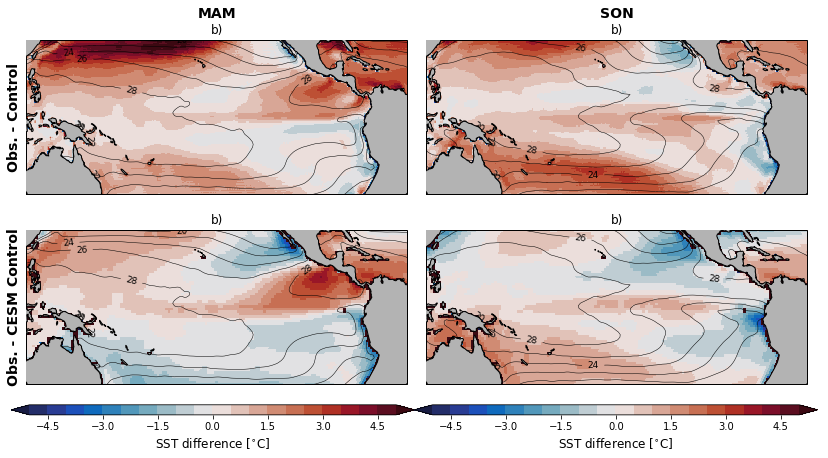

In [20]:
# MAPS COMPARING MODEL CONTROL AND OBSERVATIONS

fig = plt.figure(figsize=(14,7))

lev = np.arange(-5,5.5,0.5)
lev2 = np.arange(20,36,2)
cmap =cmocean.cm.balance
proj = ccrs.Mollweide(central_longitude=-180)

ax1 = plt.subplot(2,2,1,projection=proj)
ax1.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im2 = seas_diff['obs']['ctrl'].sel(season='MAM').plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
CS = seasmean['obs'].sel(season='MAM').plot.contour(colors='k',levels=lev2, linewidths=0.5, transform=ccrs.PlateCarree())
ax1.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax1.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax1.set_title('b)')

ax2 = plt.subplot(2,2,2,projection=proj)
ax2.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im2 = seas_diff['obs']['ctrl'].sel(season='SON').plot(ax=ax2, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
CS = seasmean['obs'].sel(season='SON').plot.contour(colors='k',levels=lev2, linewidths=0.5, transform=ccrs.PlateCarree())
ax2.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax2.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax2.set_title('b)')

ax3 = plt.subplot(2,2,3,projection=proj)
ax3.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im2 = seas_diff['obs']['cesm_ctrl'].sel(season='MAM').plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
CS = seasmean['obs'].sel(season='MAM').plot.contour(colors='k',levels=lev2, linewidths=0.5, transform=ccrs.PlateCarree())
ax3.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax3.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax3.set_title('b)')

ax4 = plt.subplot(2,2,4,projection=proj)
ax4.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im2 = seas_diff['obs']['cesm_ctrl'].sel(season='SON').plot(ax=ax4, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
CS = seasmean['obs'].sel(season='SON').plot.contour(colors='k',levels=lev2, linewidths=0.5, transform=ccrs.PlateCarree())
ax4.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax4.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax4.set_title('b)')

#Colorbars

fig.subplots_adjust(wspace=0.05,hspace=0.0)
cb2_ax = fig.add_axes([0.11, 0.1, 0.4, 0.02])
cb2 = fig.colorbar(im2, cax=cb2_ax, orientation='horizontal')
cb2.ax.set_xlabel('SST difference [$^{\circ}$C]', fontsize=12)

cb2_ax = fig.add_axes([0.51, 0.1, 0.4, 0.02])
cb2 = fig.colorbar(im2, cax=cb2_ax, orientation='horizontal')
cb2.ax.set_xlabel('SST difference [$^{\circ}$C]', fontsize=12)

#labels
ax1.text(0.5,1.14,'MAM',fontsize = 14, transform=ax1.transAxes, horizontalalignment='center', fontweight='bold')
ax2.text(0.5,1.14,'SON',fontsize = 14, transform=ax2.transAxes, horizontalalignment='center', fontweight='bold')

ax1.text(-0.05,0.5,'Obs. - Control',fontsize = 14, transform=ax1.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')
ax3.text(-0.05,0.5,'Obs. - CESM Control',fontsize = 14, transform=ax3.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')

#plt.tight_layout()

#plt.savefig('sst_map_mam-son.png',dpi = 600)
plt.savefig('sst_bias_mam-son.pdf')

Text(0, 0.5, 'SST [$^{\\circ}$C]')

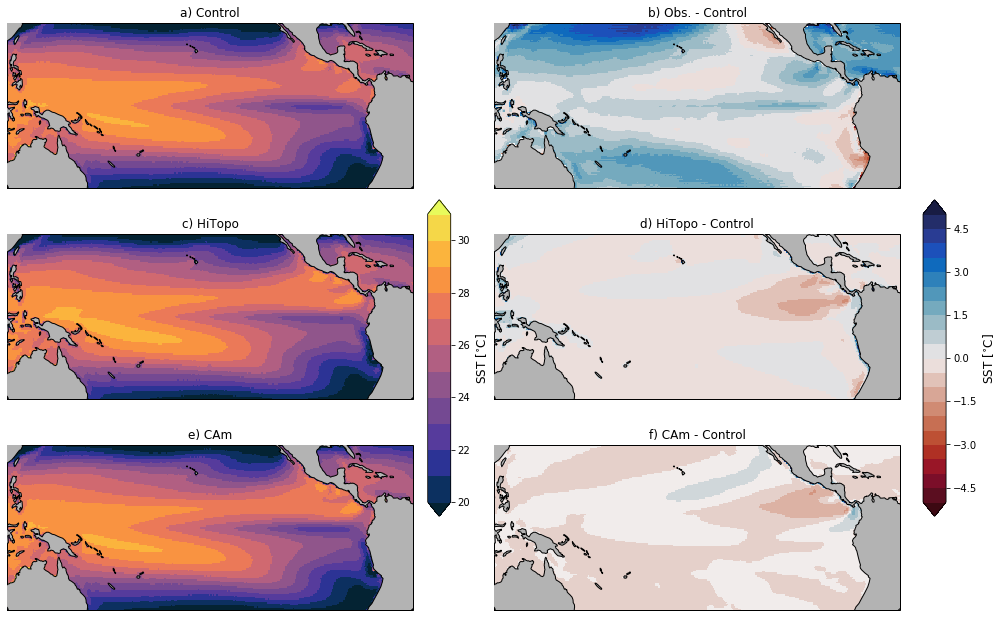

In [11]:
# MAPS COMPARING DIFFERENT MODEL RUNS

fig = plt.figure(figsize=(16,11))

lev = np.arange(20,32,1)
lev2 = np.arange(-5,5.5,0.5)
cmap = cmocean.cm.thermal
cmap2 =cmocean.cm.balance_r
cmap2r = cmocean.cm.balance
proj = ccrs.Mollweide(central_longitude=-180)

ax1 = plt.subplot(3,2,1,projection=proj)
ax1.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im1 = tmean['ctrl'].plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax1.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax1.set_title('a) Control')

ax2 = plt.subplot(3,2,2,projection=proj)
ax2.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im2 = diff['obs']['ctrl'].plot(ax=ax2, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree(), add_colorbar = False)
ax2.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax2.set_title('b) Obs. - Control')

ax3 = plt.subplot(3,2,3,projection=proj)
ax3.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
tmean['hitopo'].plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax3.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax3.set_title('c) HiTopo')

ax4 = plt.subplot(3,2,4,projection=proj)
ax4.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
mdiff['hitopo'].plot(ax=ax4, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax4.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax4.set_title('d) HiTopo - Control')

ax5 = plt.subplot(3,2,5,projection=proj)
ax5.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
tmean['cam'].plot(ax=ax5, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax5.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax5.set_title('e) CAm')

ax6 = plt.subplot(3,2,6,projection=proj)
ax6.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
mdiff['cam'].plot(ax=ax6, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax6.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax6.set_title('f) CAm - Control')

#fig.subplots_adjust(wspace=0.7)
cb1_ax = fig.add_axes([0.49, 0.25, 0.02, 0.4])
cb1 = fig.colorbar(im1, cax=cb1_ax)
cb1.ax.set_ylabel('SST [$^{\circ}$C]', rotation=90, fontsize=12)

cb2_ax = fig.add_axes([0.92, 0.25, 0.02, 0.4])
cb2 = fig.colorbar(im2, cax=cb2_ax)
cb2.ax.set_ylabel('SST [$^{\circ}$C]', rotation=90, fontsize=12)

#plt.tight_layout(w_pad = 0)

#plt.savefig('sst_map_ann.png',dpi = 600)


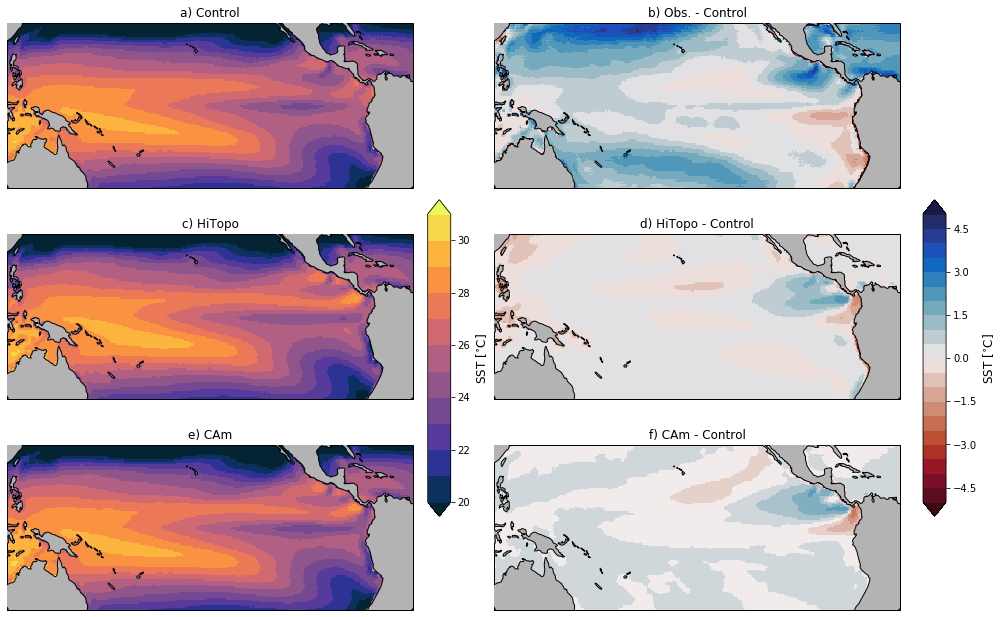

In [64]:
# MAPS COMPARING DIFFERENT MODEL RUNS SEASONAL AVERAGE

fig = plt.figure(figsize=(16,11))

lev = np.arange(20,32,1)
lev2 = np.arange(-5,5.5,0.5)
cmap = cmocean.cm.thermal
cmap2 =cmocean.cm.balance_r
cmap2r = cmocean.cm.balance
proj = ccrs.Mollweide(central_longitude=-180)

season = 'DJF'

ax1 = plt.subplot(3,2,1,projection=proj)
ax1.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im1 = seasmean['ctrl'].sel(season=season).plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax1.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax1.set_title('a) Control')

ax2 = plt.subplot(3,2,2,projection=proj)
ax2.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im2 = seas_diff['obs']['ctrl'].sel(season=season).plot(ax=ax2, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree(), add_colorbar = False)
ax2.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax2.set_title('b) Obs. - Control')

ax3 = plt.subplot(3,2,3,projection=proj)
ax3.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
seasmean['hitopo'].sel(season=season).plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax3.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax3.set_title('c) HiTopo')

ax4 = plt.subplot(3,2,4,projection=proj)
ax4.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
seas_mdiff['hitopo'].sel(season=season).plot(ax=ax4, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax4.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax4.set_title('d) HiTopo - Control')

ax5 = plt.subplot(3,2,5,projection=proj)
ax5.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
seasmean['cam'].sel(season=season).plot(ax=ax5, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax5.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax5.set_title('e) CAm')

ax6 = plt.subplot(3,2,6,projection=proj)
ax6.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
seas_mdiff['cam'].sel(season=season).plot(ax=ax6, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax6.add_feature(feature.LAND, zorder=100, edgecolor='k', facecolor = '0.7')
ax6.set_title('f) CAm - Control')

#fig.subplots_adjust(wspace=0.7)
cb1_ax = fig.add_axes([0.49, 0.25, 0.02, 0.4])
cb1 = fig.colorbar(im1, cax=cb1_ax)
cb1.ax.set_ylabel('SST [$^{\circ}$C]', rotation=90, fontsize=12)

cb2_ax = fig.add_axes([0.92, 0.25, 0.02, 0.4])
cb2 = fig.colorbar(im2, cax=cb2_ax)
cb2.ax.set_ylabel('SST [$^{\circ}$C]', rotation=90, fontsize=12)

#plt.tight_layout(w_pad = 0)

plt.savefig('sst_map_'+season+'.png',dpi = 600)